# Sensor Component Failure Prediction

## 1) Problem statement.
### Data: Sensor Data

### Problem statement :

The system in focus is the Air Pressure system (APS) which generates pressurized air that are utilized in various functions in a truck, such as braking and gear changes. The datasets positive class corresponds to component failures for a specific component of the APS system. The negative class corresponds to trucks with failures for components not related to the APS system.

The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

True class	Positive	Negative	
Predicted class			
Positive	-	cost_1	
Negative	cost_2		
Cost 1 = 10 and Cost 2 = 500

The total cost of a prediction model the sum of Cost_1 multiplied by the number of Instances with type 1 failure and Cost_2 with the number of instances with type 2 failure, resulting in a Total_cost. In this case Cost_1 refers to the cost that an unnessecary check needs to be done by an mechanic at an workshop, while Cost_2 refer to the cost of missing a faulty truck, which may cause a breakdown.

Total_cost = Cost_1 * No_Instances + Cost_2 * No_Instances.

From the above problem statement we could observe that, we have to reduce false positives and false negatives. More importantly we have to reduce false negatives, since cost incurred due to false negative is 50 times higher than the false positives.

### Challenges and other objectives
1. Need to Handle many Null values in almost all columns
2. No low-latency requirement.
3. Interpretability is not important.
4. misclassification leads the unecessary repair costs.

## 2) Import necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import PowerTransformer
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix


from sklearn import metrics 
from sklearn.model_selection import  train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier

warnings.filterwarnings("ignore")
%matplotlib inline

## Read data

In [2]:
df = pd.read_csv('data/aps_failure_training_set.csv',na_values="na")
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,pos,153204,0.0,182.0,NaN,0.0,0.0,0.0,0.0,0.0,...,129862.0,26872.0,34044.0,22472.0,34362.0,0.0,0.0,0.0,0.0,0.0
1,pos,453236,NaN,2926.0,NaN,0.0,0.0,0.0,0.0,222.0,...,7908038.0,3026002.0,5025350.0,2025766.0,1160638.0,533834.0,493800.0,6914.0,0.0,0.0
2,pos,72504,NaN,1594.0,1052.0,0.0,0.0,0.0,244.0,178226.0,...,1432098.0,372252.0,527514.0,358274.0,332818.0,284178.0,3742.0,0.0,0.0,0.0
3,pos,762958,NaN,NaN,NaN,NaN,NaN,776.0,281128.0,2186308.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,pos,695994,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1397742.0,495544.0,361646.0,28610.0,5130.0,212.0,0.0,0.0,NaN,NaN


In [3]:
df.shape

(36188, 171)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36188 entries, 0 to 36187
Columns: 171 entries, class to eg_000
dtypes: float64(169), int64(1), object(1)
memory usage: 47.2+ MB


In [5]:
### Checking unique data of target variables
df['class'].value_counts()


neg    35188
pos     1000
Name: class, dtype: int64

In [6]:
### defining categorical and numerical data
numerical_features = [column for column in df.columns if df[column].dtype!='O']
categorical_features = [column for column in df.columns if df[column].dtype=='O']

In [7]:
print(f"There are {len(numerical_features)} numerical features and they are : {numerical_features}")
print(f"There are {len(categorical_features)} categorical feature and it is : {categorical_features}")

There are 170 numerical features and they are : ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj

## As this is sensor data, interpretation is not important

### Checking missing values

In [8]:
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False)
missing.values.T[0]

array([81.41096496, 80.50182381, 78.79407538, 77.08632696, 77.08632696,
       76.53365757, 72.76168896, 65.51895656, 45.13927269, 38.19774511,
       25.42279209, 25.42279209, 25.42279209, 25.42279209, 25.42279209,
       23.54924284, 23.54924284, 23.54924284, 23.54924284, 23.54924284,
       23.54924284, 23.54924284, 23.54924284, 23.54924284, 17.15762131,
       16.5275782 , 15.93069526, 15.93069526,  7.69039461,  7.59644081,
        7.03548138,  7.03271803,  7.03271803,  7.03271803,  7.03271803,
        7.02995468,  7.02995468,  7.02995468,  7.02719133,  5.91632585,
        5.2365425 ,  5.23377915,  4.78611694,  4.78611694,  4.78611694,
        4.78611694,  4.78611694,  4.7833536 ,  4.7833536 ,  4.7833536 ,
        4.7833536 ,  4.78059025,  4.78059025,  4.78059025,  4.78059025,
        4.78059025,  4.7778269 ,  4.7778269 ,  4.7778269 ,  4.7778269 ,
        4.7778269 ,  4.7778269 ,  4.39648502,  4.39372168,  4.39372168,
        4.39095833,  4.38819498,  4.38543163,  4.38543163,  4.38

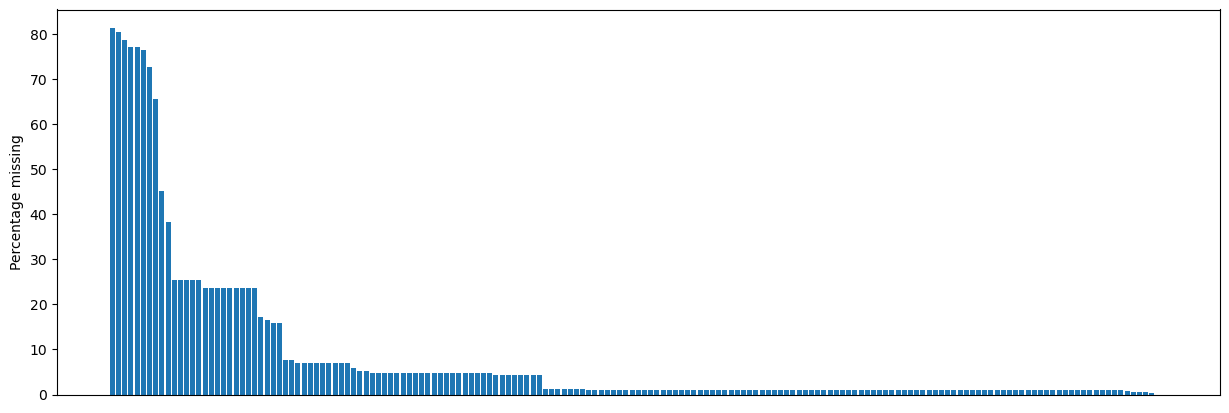

In [9]:
fig,ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0,ascending=False)

ax.bar(missing.index,missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [10]:
### Dropping columns with more than 70 percent missing values
drop_cols = missing[missing[0]>70]
drop_cols.index

Index(['br_000', 'bq_000', 'bp_000', 'ab_000', 'cr_000', 'bo_000', 'bn_000'], dtype='object')

In [11]:
df.drop(columns=drop_cols.index,axis=1,inplace=True)

In [12]:
# Let's check the missing value % now after dropping all those columns
df.isna().sum().div(df.shape[0]).mul(100)

class      0.000000
aa_000     0.000000
ac_000     5.916326
ad_000    25.422792
ae_000     4.385432
            ...    
ee_007     1.047309
ee_008     1.047309
ee_009     1.047309
ef_000     4.780590
eg_000     4.777827
Length: 164, dtype: float64

In [13]:
missing_values_total = df.isna().sum().sum()
number_of_cells = np.product(df.shape)

print("% of missing values now = {}".format((missing_values_total/number_of_cells)*100))

% of missing values now = 5.37059852747306


### Visualization of unique values in target feature

In [21]:
pos_values = df[df['class']=='pos'].shape[0]
neg_values = df[df['class']=='neg'].shape[0]

Pos values = 1000
Neg values = 35188


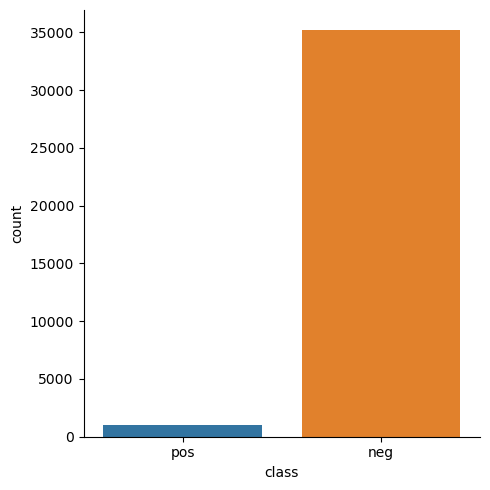

In [22]:
print(f"Pos values = {pos_values}")
print(f"Neg values = {neg_values}")
sns.catplot(data=df,x='class',kind='count')

### Report

1. The target classes are highly imbalanced
2. Class imbalance is a scenario that arises when we have unequal distribution of class in a dataset i.e. the no. of data points in the negative class (majority class) very large compared to that of the positive class (minority class)
3. If the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model.
4. Hence we should handle imbalanced data with certain methods.

### How to handle imbalanced data?

1. Resampling data is one of the most commonly preferred approaches to deal with an imbalanced dataset. There are broadly two types of methods for this i) Undersampling ii) Oversampling. In most cases, oversampling is preferred over undersampling techniques. The reason being, in undersampling we tend to remove instances from data that may be carrying some important information.
2. SMOTE: Synthetic Minority Oversampling Technique
3. SMOTE is an oversampling technique where the synthetic samples are generated for the minority class.
4. Hybridization techniques involve combining both undersampling and oversampling techniques. This is done to optimize the performance of classifier models for the samples created as part of these techniques.
5. It only duplicates the data and it won't add and new information. Hence we look at some different techniques.